In [19]:
#load and see the shape of dataset

import pandas as pd
df=pd.read_csv("weatherAUS.csv")
print(df.shape)

(145460, 23)


In [20]:
#drop rows with NANs
row_nan=df.isnull().mean(axis=1) #axis=1 means column
df=df[row_nan<0.3] #drop rows with more than 30% nan
print(df.shape)

(138502, 23)


In [21]:
#convert yes/no into 1/0 in relevant columns
bin_cols=["RainToday","RainTomorrow"]
df[bin_cols] = df[bin_cols].replace({'Yes':1,'No':0}).astype('Int64')
print(df.shape)
print(df[bin_cols].dtypes)

(138502, 23)
RainToday       Int64
RainTomorrow    Int64
dtype: object


C:\Users\HP\AppData\Local\Temp\ipykernel_6536\928695443.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bin_cols] = df[bin_cols].replace({'Yes':1,'No':0}).astype('Int64')


In [22]:
#encoding labels(convert text to numerical)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cat_col=df.select_dtypes(include='object').columns
for col in cat_col:
    df[col]=df[col].astype(str)
    df[col]=le.fit_transform(df[col])

In [23]:
#drop unnecessary columns
drp_col=["Date","Location"]
df=df.drop(columns=drp_col)
print(df.shape)

(138502, 21)


In [24]:
#fill the remaining NANs with median (skewness in columns)
df=df.fillna(df.median(numeric_only=True))
print(df.isnull().sum().sum())

0


In [25]:
#run random-forest for rain tomorrow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

#separate features and label
x=df.drop("RainTomorrow",axis=1)
y=df["RainTomorrow"]

#split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) #test in 20% of data, random_state=Controls the shuffling applied to the data before applying the split

#train the model 100 trees in forest and predict
model=RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

#evaluate
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:", round(accuracy * 100, 2), "%")

Accuracy: 85.81 %


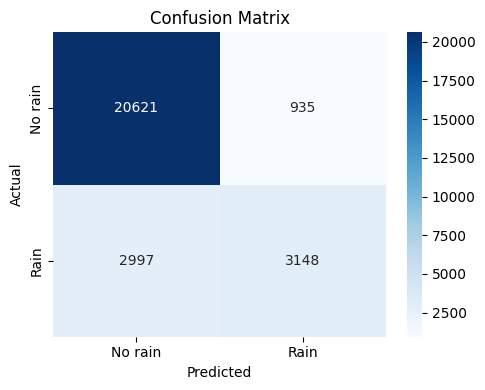

In [26]:
#plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=[5,4])
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["No rain","Rain"],yticklabels=["No rain","Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

So, no rain is predicted correctly for 20621 times and rain for 3148 times. Missed rain 2997 times. False alarm 935 times. Hence, the model performs well at predicting no rain days.

C:\Users\HP\AppData\Local\Temp\ipykernel_6536\184827068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imptncs[indices][:10],y=feature_names[indices][:10], palette="viridis")


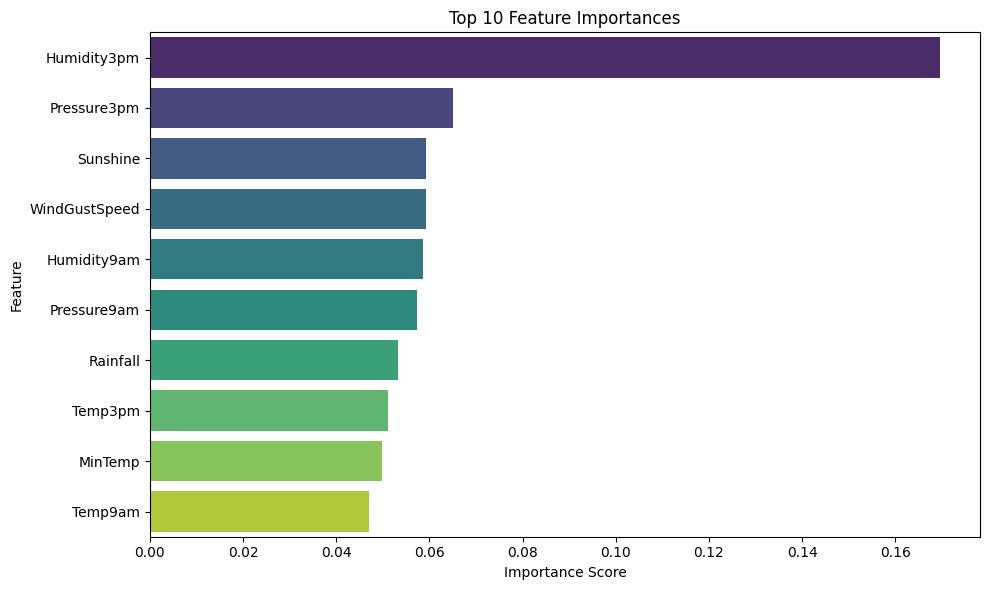

In [27]:
#feature importance plot
import numpy as np
imptncs=model.feature_importances_
feature_names=x.columns
indices = np.argsort(imptncs)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=imptncs[indices][:10],y=feature_names[indices][:10], palette="viridis")
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The model identified Humidity at 3PM as the most important predictor of rainfall. This aligns with real-world weather patterns, where high afternoon humidity often signals increased chances of rain.

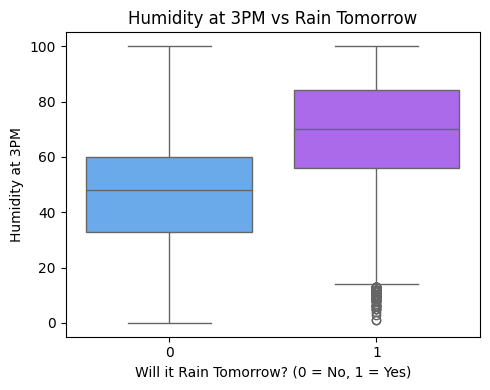

In [29]:
#box plot of humidity vs rain tomorrow
plt.figure(figsize=(5,4))
sns.boxplot(x='RainTomorrow', y='Humidity3pm', hue='RainTomorrow', data=df, palette='cool', legend=False)

plt.title('Humidity at 3PM vs Rain Tomorrow')
plt.xlabel('Will it Rain Tomorrow? (0 = No, 1 = Yes)')
plt.ylabel('Humidity at 3PM')
plt.tight_layout()
plt.show()

So for approximately 58%-85% humidity at 3pm predicts there's a higher chance of rainfall tomorrow.